In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# read_data
col_name = ["User_ID", "Stream_ID", "Streamer_username", "Time_start", "Time_stop"]
df = pd.read_csv('/content/100k_a.csv',header = None, names = col_name)
df.head()

,User_ID,Stream_ID,Streamer_username,Time_start,Time_stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594


In [3]:
# add rating column 

df["rating"] = (df["Time_stop"] - df["Time_start"])*10
df.head()

,User_ID,Stream_ID,Streamer_username,Time_start,Time_stop,rating
0,1,33842865744,mithrain,154,156,20
1,1,33846768288,alptv,166,169,30
2,1,33886469056,mithrain,587,588,10
3,1,33887624992,wtcn,589,591,20
4,1,33890145056,jrokezftw,591,594,30


In [4]:
# grouping User_id, Streamer_id and add rating
df = df.groupby(['User_ID', 'Streamer_username']).agg({'rating': 'sum'}).reset_index()

df

,User_ID,Streamer_username,rating
0,1,alptv,30
1,1,berkriptepe,30
2,1,elraenn,20
3,1,eraymaskulen,10
4,1,esl_csgo,10
...,...,...,...
1505153,100000,mckytv,10
1505154,100000,natehill,10
1505155,100000,ninja,30
1505156,100000,replays,10


In [5]:
# scaling rating
scaler = StandardScaler()
df['rating'] = scaler.fit_transform(df[['rating']])

df

,User_ID,Streamer_username,rating
0,1,alptv,-0.258711
1,1,berkriptepe,-0.258711
2,1,elraenn,-0.335466
3,1,eraymaskulen,-0.412222
4,1,esl_csgo,-0.412222
...,...,...,...
1505153,100000,mckytv,-0.412222
1505154,100000,natehill,-0.412222
1505155,100000,ninja,-0.258711
1505156,100000,replays,-0.412222


In [6]:
# train, test data set
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
# ramdom sampling 20000
sampled_df = train_df.sample(n=20000, random_state=42)

In [7]:
# User ID, Stream ID numeratic index
user_ids, user_names = pd.factorize(sampled_df['User_ID'])
stream_ids, stream_names = pd.factorize(sampled_df['Streamer_username'])

ratings_data = sampled_df['rating'].values.astype(np.int32)

# csr_matrix
ratings = csr_matrix(
    (sampled_df['rating'].values, (user_ids, stream_ids)),
    shape=(len(np.unique(user_ids)), len(np.unique(stream_ids)))
).toarray()

In [10]:
class MatrixFactorization():
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate  # eta0 Constant that multiplies the update term
        self.alpha = alpha  # lambda Constant that multiplies the regularization term
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    # initialize
    def initialize(self, ):
        self.now = time.time()
        # Initialize Bias Values
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # initialize user & item vectors
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        # compute global bias
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    # predict
    def predict(self, u, i):
        return self.global_bias+self.user_biases[u]+self.item_biases[i]+self.user_vecs[u]@self.item_vecs[i]

    # updata user, item matrix
    def update_biases_and_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate*(error - self.alpha*self.user_biases[u])
        self.item_biases[i] += self.l_rate*(error - self.alpha*self.item_biases[i])
        # Update User and item Vectors
        self.user_vecs[u, :] += self.l_rate*(error*self.item_vecs[i, :] - self.alpha*self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate*(error*self.user_vecs[u, :] - self.alpha*self.item_vecs[i, :])

    # model test and output MSE
    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            # Extracting user item information indices in which we have a rating
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i]-pred_rat)**2
        mse = tot_square_error/self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time()-self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    # epoch early stopping
    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time()-self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    # training function
    def fit(self, ):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if self.stop == False:
                for index in self.ind_lst:
                    # Extracting user item information indices in which we have a rating
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i]-pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.conv_epoch_num = epoch
        self.plot_the_score()

    def result(self):
        return (self.user_vecs, self.item_vecs)

    # plot MSE each epoch
    def plot_the_score(self, ):
        plt.figure(figsize=(18,6))
        plt.plot(range(1, 1+len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("SGD Custom Prepared USER & ITEM vector's Tr MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num+5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst),15), fontsize=15)
        plt.grid()
        plt.show()

---> Epoch 0
ave mse 0.988 ===> Total training time: 0.707 seconds.
---> Epoch 1
ave mse 0.941 ===> Total training time: 1.199 seconds.
---> Epoch 2
ave mse 0.903 ===> Total training time: 1.673 seconds.
---> Epoch 3
ave mse 0.868 ===> Total training time: 2.142 seconds.
---> Epoch 4
ave mse 0.837 ===> Total training time: 2.6 seconds.
---> Epoch 5
ave mse 0.808 ===> Total training time: 3.079 seconds.
---> Epoch 6
ave mse 0.781 ===> Total training time: 3.553 seconds.
---> Epoch 7
ave mse 0.755 ===> Total training time: 4.027 seconds.
---> Epoch 8
ave mse 0.731 ===> Total training time: 4.49 seconds.
---> Epoch 9
ave mse 0.708 ===> Total training time: 4.987 seconds.
---> Epoch 10
ave mse 0.686 ===> Total training time: 5.44 seconds.
---> Epoch 11
ave mse 0.664 ===> Total training time: 5.914 seconds.
---> Epoch 12
ave mse 0.643 ===> Total training time: 6.378 seconds.
---> Epoch 13
ave mse 0.623 ===> Total training time: 6.836 seconds.
---> Epoch 14
ave mse 0.603 ===> Total training 

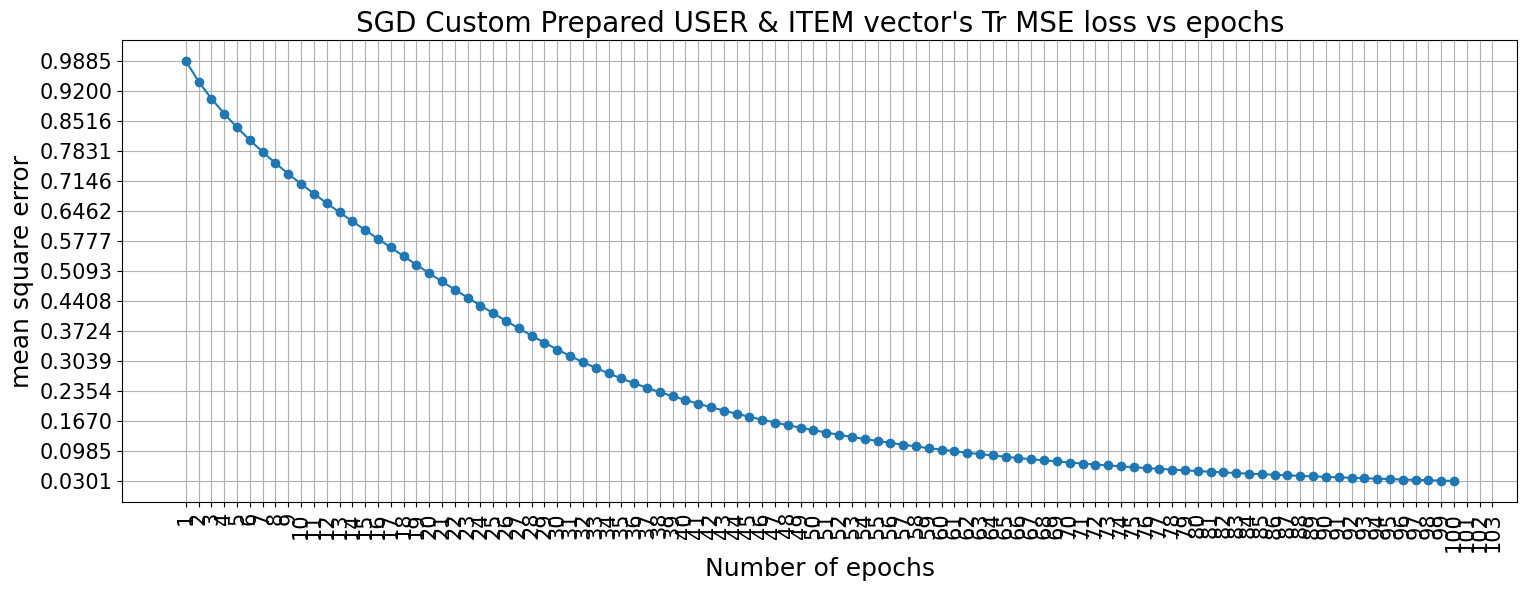

In [11]:
obj = MatrixFactorization(ratings)
# train
obj.fit()

In [12]:
user, item = obj.result()

# output print
print(user.shape)
print(item.shape)
print(user_ids)
print(stream_ids)
print(user_names)
print(stream_names)

(16859, 100)
(9531, 100)
[    0     1     2 ... 16857  7186 16858]
[   0    1    2 ... 9529 9530  425]
Int64Index([40979,  5349,  2416, 21447, 32800, 95335, 64153, 98060, 17919,
            96216,
            ...
            33890, 19412, 68665, 52695, 33862,  8608, 85309, 51474, 37273,
            49257],
           dtype='int64', length=16859)
Index(['mattsuo', 'lestream', 'chap', 'vda_pedro', 'playstation', 'scrub',
       'whiteysnakey', 'c9sneaky', 'smgxprincess', 'jasonr',
       ...
       'gizmo1739', 'exileforcex', 'slader1hp', 'icelinedion',
       'itsameinvasion', 'drakanous', 'thebubbaarmy', 'rose_eviata',
       'lessthanbrie', 'sloth'],
      dtype='object', length=9531)


In [13]:
matrix2_transposed = item.T

# user X item = predict rating matrix
result_matrix = np.dot(user, matrix2_transposed)

In [14]:
result_df = pd.DataFrame(result_matrix, index=user_names, columns=stream_names)

result_df

,mattsuo,lestream,chap,vda_pedro,playstation,scrub,whiteysnakey,c9sneaky,smgxprincess,jasonr,...,gizmo1739,exileforcex,slader1hp,icelinedion,itsameinvasion,drakanous,thebubbaarmy,rose_eviata,lessthanbrie,sloth
40979,-0.001298,0.001991,-0.005016,0.000611,-0.000677,0.001820,0.000637,0.003520,0.001461,0.002351,...,0.000010,0.000010,0.000030,0.000958,0.000511,0.001037,-0.000806,-0.000900,-0.000189,0.000984
5349,-0.000940,-0.002493,0.001461,-0.000936,-0.000361,-0.000538,0.000285,0.004499,0.000428,0.000904,...,-0.001777,-0.001450,-0.000399,-0.000803,0.000094,-0.000949,0.000671,0.000370,0.001896,0.001284
2416,-0.000381,-0.001194,0.004714,0.001661,-0.000353,0.000369,0.000433,-0.010150,0.000307,0.001574,...,-0.000432,0.000947,0.000230,0.000191,-0.001512,0.000226,-0.002266,-0.000277,-0.000259,-0.000100
21447,-0.000583,-0.001463,0.003447,-0.004681,-0.000501,0.000110,-0.000460,-0.004391,-0.000806,-0.000081,...,0.000454,-0.000570,-0.000992,-0.000459,0.000673,0.000129,0.000428,-0.000223,0.002293,-0.001087
32800,-0.000043,0.001239,0.000236,0.001011,0.005519,-0.000303,0.001123,-0.001429,0.000271,-0.001452,...,0.000022,-0.000616,-0.000052,-0.000219,-0.000747,0.000042,0.000658,-0.001652,-0.001144,-0.002050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,0.001299,-0.000858,0.002069,0.000411,-0.000049,-0.000050,-0.000757,0.012720,0.001226,0.001898,...,0.000378,0.000829,0.000360,-0.000302,0.002349,-0.000047,-0.000053,0.000177,0.000564,0.002818
85309,0.004147,0.002972,-0.002479,-0.006106,-0.008582,0.012108,0.006235,0.155397,0.004978,-0.007065,...,-0.005779,-0.004411,0.005149,0.011293,0.005354,0.005032,-0.008451,-0.007546,0.005340,0.000293
51474,-0.001486,0.001649,-0.000546,0.000008,0.000843,0.000385,0.000251,-0.025251,0.000030,-0.001420,...,-0.000719,-0.000481,-0.000107,-0.000874,0.001387,0.000871,0.001099,-0.001180,0.000457,-0.001374
37273,-0.000132,0.000574,-0.002735,0.000193,0.000054,0.000281,-0.000522,-0.044993,0.000619,-0.000957,...,0.000664,-0.002057,0.001197,0.000202,0.001419,0.000864,-0.000018,-0.000170,-0.005295,0.000953


In [15]:
result_df = result_df.sort_index(axis=0)

# print matching user favorite streamer
result_name = []
result_streamer = []
for i in range(len(result_df)):
  print(f"{result_df.iloc[i].name} 가 가장 좋아하는 스트리머는 {result_df.iloc[i].idxmax()}")
  result_name.append(result_df.iloc[i].name)
  result_streamer.append(result_df.iloc[i].idxmax())

result_pd = pd.DataFrame({
    "User" : result_name,
    "Streamer" : result_streamer
})

result_pd.to_csv("/content/matrix_factorization_50000.csv",mode="w")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
71017 가 가장 좋아하는 스트리머는 happasc2
71025 가 가장 좋아하는 스트리머는 hanryang1125
71040 가 가장 좋아하는 스트리머는 maximilian_dood
71042 가 가장 좋아하는 스트리머는 shroud
71044 가 가장 좋아하는 스트리머는 faunafrog
71045 가 가장 좋아하는 스트리머는 jazyyyyy1215
71046 가 가장 좋아하는 스트리머는 monagua
71058 가 가장 좋아하는 스트리머는 ni_coyomi
71084 가 가장 좋아하는 스트리머는 elwind
71087 가 가장 좋아하는 스트리머는 tsm_hamlinz
71088 가 가장 좋아하는 스트리머는 agraelus
71091 가 가장 좋아하는 스트리머는 ellohime
71092 가 가장 좋아하는 스트리머는 mithrain
71095 가 가장 좋아하는 스트리머는 xqcow
71099 가 가장 좋아하는 스트리머는 sanux
71121 가 가장 좋아하는 스트리머는 gotaga
71126 가 가장 좋아하는 스트리머는 towelliee
71128 가 가장 좋아하는 스트리머는 handongsuk
71133 가 가장 좋아하는 스트리머는 faunafrog
71139 가 가장 좋아하는 스트리머는 elwind
71142 가 가장 좋아하는 스트리머는 faunafrog
71143 가 가장 좋아하는 스트리머는 fifahassliebehd
71149 가 가장 좋아하는 스트리머는 tfue
71157 가 가장 좋아하는 스트리머는 hanryang1125
71170 가 가장 좋아하는 스트리머는 overpow
71173 가 가장 좋아하는 스트리머는 moonmoon_ow
71176 가 가장 좋아하는 스트리머는 lirik
71179 가 가장 좋아하는 스트리머는 angryjoeshow
71183 가 가장 좋아하는 스트리머는 failverde
71187 가 가장 좋아하는 스트리머는 collet11
71194 가 가장 좋아

In [16]:
# test data processing if it have User_id and Streamer_username in train data and not duplicate (User_id, Streamer_username) 
unique_user_ids = sampled_df['User_ID'].unique()
unique_streamer_usernames = sampled_df['Streamer_username'].unique()

filtered_test_df = test_df[test_df['User_ID'].isin(unique_user_ids) & test_df['Streamer_username'].isin(unique_streamer_usernames)]

filtered_test_df = filtered_test_df.merge(sampled_df, on=['User_ID', 'Streamer_username'], how='left', indicator=True)
filtered_test_df = filtered_test_df[filtered_test_df['_merge'] == 'left_only']

filtered_test_df = filtered_test_df.drop(columns=['_merge'])


print(filtered_test_df)

# calculate mae
sum_error = 0 

for index, row in filtered_test_df.iterrows():
    predicted_rating = result_df.loc[row["User_ID"], row["Streamer_username"]]
    actual_rating = row["rating_x"]
    error = abs(predicted_rating - actual_rating)
    sum_error += error

print(sampled_df["rating"].describe())
print(sum_error/len(filtered_test_df))


       User_ID Streamer_username  rating_x  rating_y
0        36995       thomaspaste  1.736939       NaN
1        35010             xqcow -0.258711       NaN
2        75136             ajehr -0.335466       NaN
3        32105            sleepy -0.412222       NaN
4        89852        pikabooirl -0.028443       NaN
...        ...               ...       ...       ...
53359    68043            witwix -0.181955       NaN
53360    55912        nerftanktv  0.969382       NaN
53361    62073            toqtir -0.028443       NaN
53362    36108    olesyabulletka -0.412222       NaN
53363    39200             dizzy -0.412222       NaN

[53364 rows x 4 columns]
count    20000.000000
mean         0.003238
std          0.994251
min         -0.412222
25%         -0.412222
50%         -0.335466
75%         -0.028443
max         25.224205
Name: rating, dtype: float64
0.5423915186937117


In [17]:
# similarity user
user_similarity_matrix = cosine_similarity(result_matrix)

user_similarity_matrix

array([[ 1.        , -0.0607282 ,  0.18700923, ...,  0.3661023 ,
         0.01030405, -0.0629794 ],
       [-0.0607282 ,  1.        , -0.08263601, ..., -0.0228202 ,
         0.00836602,  0.03048604],
       [ 0.18700923, -0.08263601,  1.        , ...,  0.0625951 ,
        -0.12113879,  0.07645264],
       ...,
       [ 0.3661023 , -0.0228202 ,  0.0625951 , ...,  1.        ,
         0.15525964,  0.07926187],
       [ 0.01030405,  0.00836602, -0.12113879, ...,  0.15525964,
         1.        ,  0.01461248],
       [-0.0629794 ,  0.03048604,  0.07645264, ...,  0.07926187,
         0.01461248,  1.        ]])

In [18]:
result_df = pd.DataFrame(user_similarity_matrix, index=user_names, columns=user_names)

result_df

,40979,5349,2416,21447,32800,95335,64153,98060,17919,96216,...,33890,19412,68665,52695,33862,8608,85309,51474,37273,49257
40979,1.000000,-0.060728,0.187009,-0.236212,0.250118,-0.117017,-0.055502,0.097068,-0.184017,-0.109502,...,-0.105637,0.097450,-0.070513,-0.037530,0.200971,0.100051,0.150813,0.366102,0.010304,-0.062979
5349,-0.060728,1.000000,-0.082636,0.184846,-0.109661,-0.118364,-0.017376,-0.084129,0.048065,0.051070,...,-0.009366,0.025009,-0.086188,0.157791,-0.137506,0.024458,0.031585,-0.022820,0.008366,0.030486
2416,0.187009,-0.082636,1.000000,0.051852,0.052376,0.061844,0.029010,0.088592,-0.353835,0.205102,...,-0.033848,0.220357,-0.011400,0.084744,0.067268,0.223255,-0.089609,0.062595,-0.121139,0.076453
21447,-0.236212,0.184846,0.051852,1.000000,-0.146355,-0.004434,0.019006,-0.020791,0.046283,-0.054527,...,-0.239722,0.168748,-0.020474,0.042389,0.027881,-0.072845,-0.026411,0.000040,-0.174100,0.031106
32800,0.250118,-0.109661,0.052376,-0.146355,1.000000,0.015001,-0.028974,0.047566,-0.045671,0.234782,...,0.007751,-0.176518,0.121656,-0.009647,0.217560,-0.074654,0.015865,0.074920,0.039157,0.082333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,0.100051,0.024458,0.223255,-0.072845,-0.074654,0.118399,0.155971,0.090635,-0.215466,0.089101,...,-0.021506,0.041808,-0.048170,-0.009512,0.116505,1.000000,-0.367451,0.026912,-0.149925,0.025001
85309,0.150813,0.031585,-0.089609,-0.026411,0.015865,-0.187859,-0.134148,-0.059756,-0.086838,-0.228905,...,0.187896,-0.019206,-0.305433,-0.086774,0.086241,-0.367451,1.000000,0.138490,0.168601,0.060872
51474,0.366102,-0.022820,0.062595,0.000040,0.074920,-0.110649,-0.064627,0.090042,-0.114712,-0.146554,...,-0.121480,0.035931,-0.080246,-0.126677,0.060293,0.026912,0.138490,1.000000,0.155260,0.079262
37273,0.010304,0.008366,-0.121139,-0.174100,0.039157,-0.008926,-0.014721,0.224417,-0.131942,-0.030117,...,0.184116,-0.145402,-0.170415,0.025797,0.040329,-0.149925,0.168601,0.155260,1.000000,0.014612


In [19]:
# print most similarity user of each user
result_name = []
result_streamer = []
for i in range(len(result_df)):
    self_index = result_df.index.get_loc(result_df.index[i])

    max_index = result_df.iloc[i][result_df.columns != result_df.index[i]].idxmax()

    print(f"{result_df.iloc[i].name} 랑 비슷한 청자는 {max_index}")
    result_name.append(result_df.iloc[i].name)
    result_streamer.append(max_index)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
41210 랑 비슷한 청자는 11595
73245 랑 비슷한 청자는 78609
23280 랑 비슷한 청자는 71976
14035 랑 비슷한 청자는 91208
30512 랑 비슷한 청자는 8375
68670 랑 비슷한 청자는 7207
74551 랑 비슷한 청자는 46994
95937 랑 비슷한 청자는 30227
91455 랑 비슷한 청자는 35624
25649 랑 비슷한 청자는 39215
31836 랑 비슷한 청자는 69304
45803 랑 비슷한 청자는 29629
3814 랑 비슷한 청자는 20296
60567 랑 비슷한 청자는 71355
16369 랑 비슷한 청자는 33761
50047 랑 비슷한 청자는 60527
16117 랑 비슷한 청자는 99235
98634 랑 비슷한 청자는 13127
779 랑 비슷한 청자는 59610
96518 랑 비슷한 청자는 72468
14699 랑 비슷한 청자는 27181
22636 랑 비슷한 청자는 69376
75942 랑 비슷한 청자는 1552
48997 랑 비슷한 청자는 56598
44958 랑 비슷한 청자는 92857
60091 랑 비슷한 청자는 21004
45707 랑 비슷한 청자는 33046
17300 랑 비슷한 청자는 82717
47329 랑 비슷한 청자는 81260
58336 랑 비슷한 청자는 20268
25051 랑 비슷한 청자는 78306
70266 랑 비슷한 청자는 2762
13641 랑 비슷한 청자는 76777
12385 랑 비슷한 청자는 6423
66929 랑 비슷한 청자는 45638
79905 랑 비슷한 청자는 19281
21334 랑 비슷한 청자는 41465
50819 랑 비슷한 청자는 80973
67989 랑 비슷한 청자는 85711
47386 랑 비슷한 청자는 96091
14801 랑 비슷한 청자는 32062
44081 랑 비슷한 청자는 53728
15167 랑 비슷한 청자는 52195
33379 랑 비슷한 청자는 10953
6128